## Деревья решений 
### Ноутбук составлен по мотивам лекций профессора Воронцова по ML для МФТИ и ШАД

Чтобы поупражняться, воспользуемся датасетом Фишера с ирисами, взятым отсюда:
https://archive.ics.uci.edu/ml/datasets/iris

In [1]:
import pandas as pd
df_iris = pd.read_csv("iris.data")
df_iris.columns = ["sepal length", "sepal width", "petal length", "petal width", "class"]
df_iris.sample(7)

,sepal length,sepal width,petal length,petal width,class
26,5.2,3.5,1.5,0.2,Iris-setosa
7,4.4,2.9,1.4,0.2,Iris-setosa
133,6.1,2.6,5.6,1.4,Iris-virginica
52,5.5,2.3,4.0,1.3,Iris-versicolor
138,6.9,3.1,5.4,2.1,Iris-virginica
13,5.8,4.0,1.2,0.2,Iris-setosa
55,6.3,3.3,4.7,1.6,Iris-versicolor


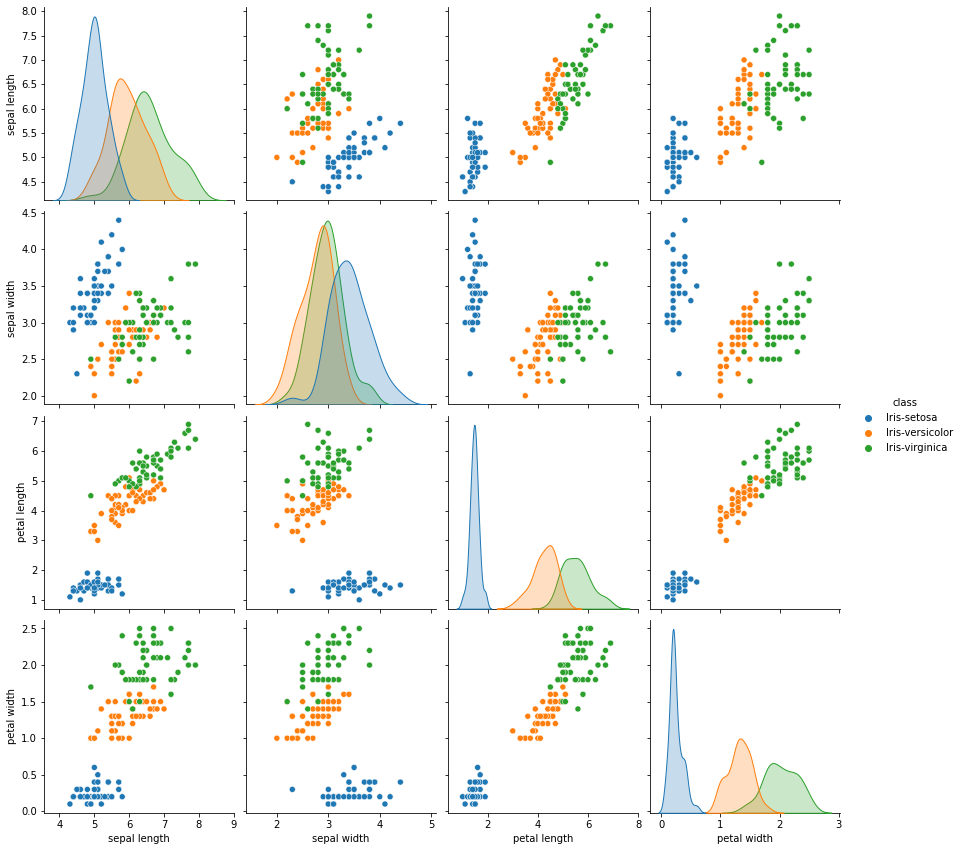

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_iris, hue='class', height=3)
plt.show()

Реализуем алгоритм ID3 - Iterative Dichotomiser 3, который используется для создания дерева. Для этого необходимо создать класс узла дерева, чтобы строить из них деревья, а также реализовать метрику Information Gain - например, энтропию или Gini impurity.

In [3]:
class Node:
    def __init__(self, left = None, right = None, value = None, feature = None, feature_val = None):
        self.__left = left
        self.__right = right
        self.__feature = feature
        self.__value = value
        self.__feature_val = feature_val
        
    @property
    def right(self):
        return self.__right
    
    @right.setter
    def right(self, right):
        if isinstance(right, Node):
            self.__right = right
        else:
            print("self.__right can only be an instance of Node")
            
    @property
    def left(self):
        return self.__left
    
    @left.setter
    def left(self, left):
        if isinstance(left, Node):
            self.__left = left
        else:
            print("self.__left can only be an instance of Node")
            
    @property
    def value(self):
        return self.__value
    
    @value.setter
    def value(self, value):
        allowed_values = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
        if value in allowed_values:
            self.__value = value
        else:
            print("self.__value can only be one of", allowed_values)
    
    @property
    def feature(self):
        return self.__feature
    
    @property
    def feature_val(self):
        return self.__feature_val

In [4]:
n1 = Node()
n_left = Node(value = "Iris-setosa")
n_right = Node(value = "Iris-versicolor")
n1.left = n_left
n1.right = n_right
n1.left.value, n1.right.value

('Iris-setosa', 'Iris-versicolor')

Вот формула для энтропии:
### $$ H(p) = -\sum_x{p(x)log(p(x))}, $$
где x - все классы, которые есть в датасете или его подмножестве (в алгоритме ID3 будем иметь дело с подмножествами)

Посчитаем энтропию исходного распределения

In [5]:
import math
def entropy(df):
    e = 0
    for i, frame in df.groupby(['class']):
        e += -len(frame)/len(df)*math.log(len(frame)/len(df), 2)
    return e

In [6]:
entropy(df_iris)

1.5848973705351974

Введем понятие прироста информации:

In [7]:
def gain(df_before, df_list_after):
    new_e = 0
    for df in df_list_after:
        new_e += entropy(df)
    return entropy(df_before) - new_e

Посмотрим, будет ли прирост информации в датасете, если из него убрать, к примеру, iris-versicolor

In [8]:
gain(df_iris, [df_iris[~(df_iris['class'] == 'Iris-versicolor')]])

0.5849709711665114

Получается, что будет - энтропия снизилась почти на единицу

ОК, поехали реализовывать ID3. По каждому из признаков нужно искать такой сплит, который даст максимальный прирост информации. Датасет с ирисами маленький, поэтому попробуем искать перебором по всем возможным вариантам

In [9]:
def create_node(df, min_gain = 0.01, level = 0, orient = 'Root'):
    level = level + 1
    max_gain = 0
    best_feature = None
    best_feature_val = None
    for col in df.columns[:-1]:
        # print("working with feature", col)
        df = df.sort_values(by=[col])
        for val in df[col]:
            df_left = df[df[col] <= val]
            df_right = df[df[col] > val]
            # print("gain = ", gain(df, [df_left, df_right]))
            g = gain(df, [df_left, df_right])
            if g > max_gain:
                max_gain = g
                best_feature = col
                best_feature_val = val
    tab = '--' * level
    if max_gain < min_gain:
        print(f"{tab} level_{level} {orient} max_gain = {max_gain}. Creating leaf node with value", df['class'].mode()[0])
        return Node(value = df['class'].mode()[0])
    
    df_left = df[df[best_feature] <= best_feature_val]
    df_right = df[df[best_feature] > best_feature_val]
    print(f"{tab} level_{level} {orient} Creating tree node with feature \"{best_feature}\", feature_val = {best_feature_val}, gain = {max_gain}")
    return Node(left = create_node(df_left, level = level, orient = 'Left'), 
                right = create_node(df_right, level = level, orient = 'Right'), 
                feature = best_feature, feature_val = best_feature_val)

In [10]:
tree = create_node(df_iris)

-- level_1 Root Creating tree node with feature "petal length", feature_val = 1.9, gain = 0.5848973705351974
---- level_2 Left max_gain = 0. Creating leaf node with value Iris-setosa
---- level_2 Right Creating tree node with feature "petal width", feature_val = 1.7, gain = 0.40383817243204767
------ level_3 Left Creating tree node with feature "petal length", feature_val = 5.1, gain = 0.1268495593676055
-------- level_4 Left max_gain = 0. Creating leaf node with value Iris-versicolor
-------- level_4 Right max_gain = 0. Creating leaf node with value Iris-virginica
------ level_3 Right max_gain = 0. Creating leaf node with value Iris-virginica


Реализуем теперь логику прохода по дереву

In [11]:
def DT(root, test_obj):
    node = root
    while not node.value:
        if test_obj[node.feature] <= node.feature_val:
            node = node.left
        else:
            node = node.right
    return node.value

In [23]:
for i, flower in df_iris.sample(15).iterrows():
    print(f"flower = {flower['class']}, classification result = {DT(tree, flower)}")

flower = Iris-setosa, classification result = Iris-setosa
flower = Iris-virginica, classification result = Iris-virginica
flower = Iris-virginica, classification result = Iris-virginica
flower = Iris-setosa, classification result = Iris-setosa
flower = Iris-virginica, classification result = Iris-virginica
flower = Iris-setosa, classification result = Iris-setosa
flower = Iris-virginica, classification result = Iris-versicolor
flower = Iris-versicolor, classification result = Iris-versicolor
flower = Iris-setosa, classification result = Iris-setosa
flower = Iris-virginica, classification result = Iris-virginica
flower = Iris-setosa, classification result = Iris-setosa
flower = Iris-versicolor, classification result = Iris-versicolor
flower = Iris-virginica, classification result = Iris-virginica
flower = Iris-setosa, classification result = Iris-setosa
flower = Iris-virginica, classification result = Iris-virginica
